# Some PCA train
## Some preparations and data import
Let's download adn unzip data.

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip
!unzip superconduct.zip



--2021-12-07 18:12:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00464/superconduct.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8300005 (7,9M) [application/x-httpd-php]
Saving to: ‘superconduct.zip.1’

superconduct.zip.1  100%[===================>]   7,92M   400KB/s    in 20s     

2021-12-07 18:12:45 (400 KB/s) - ‘superconduct.zip.1’ saved [8300005/8300005]



Import all needed libraries

In [1]:
import os
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA # Основной класс, который нам нужен
from sklearn.preprocessing import StandardScaler

let's set some params

In [2]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
np.random.seed(42)

Reading data

In [3]:
file1 = pd.read_csv('train.csv')
file2 = pd.read_csv('unique_m.csv')


In [4]:
print(file1.shape, file2.shape)

(21263, 82) (21263, 88)


number of observation is equal. Let's concatenate dfs and drop material column and duplicate column

In [5]:
data = pd.concat((file1,file2),axis=1).drop(columns = 'material')
data = data.loc[:,~data.columns.duplicated()]

Propper number of rows and columns (column 'material is removed).


In [6]:
abscent_boys = list(data.columns[data.std() == 0])
print(abscent_boys)

['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']


Bu we have 9 columns with constant values. Let's remove this

In [7]:
data = data.drop(columns=abscent_boys)

In [8]:
data.shape

(21263, 159)

Minus 9 features! Let's go!

## Data standartization
First of all, let's split our dataset intro train and test datasets

In [9]:
train, test = train_test_split(data, test_size=0.2, random_state=47)
print(train.shape, test.shape)

(17010, 159) (4253, 159)


Looks splited fine. Let's separate features and target value

In [10]:
X_train, y_train = train.drop(columns='critical_temp'), train['critical_temp']
X_test, y_test = test.drop(columns='critical_temp'), test['critical_temp']

Let's Z-score normalize our data and save respective value.

In [11]:
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_z_norm = (X_train - X_train_mean)/X_train_std
X_test_z_norm = (X_test - X_train_mean)/X_train_std


Let's train some linear model for our features

In [12]:
reg = LinearRegression().fit(X_train_z_norm, y_train)
R2 = reg.score(X_test_z_norm, y_test)
n, p = X_test_z_norm.shape
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)  
adj_R2

0.7591200650654967

Here we have it! Good model. But is it enough?

You can read about adjusted R2 here: https://stackoverflow.com/questions/49381661/how-do-i-calculate-the-adjusted-r-squared-score-using-scikit-learn

## PCA
Let's try PCA now


In [13]:
pca = PCA(n_components=X_train_z_norm.shape[1])
pca.fit(X_train_z_norm)

PCA(n_components=158)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


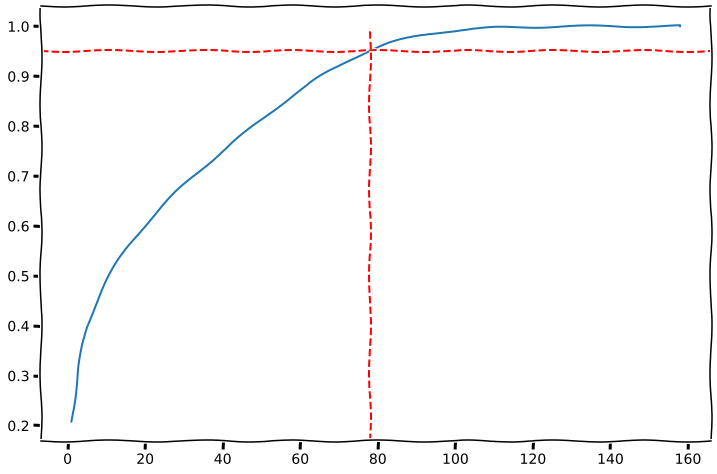

In [14]:
ths = 0.95
total_explained = np.cumsum(pca.explained_variance_ratio_)


with plt.xkcd():  # cool stuff:)
    plt.plot(np.arange(1, total_explained.shape[0] + 1), total_explained)
    plt.axhline(xmin=0, xmax=1000, y=ths, c="red", ls="--")
    chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
    plt.axvline(x=chosen_number, ymin=0, ymax=ths, c="red", ls="--")
    plt.text(800, 0.7, f"n PCs = {chosen_number}", clip_on=True);

Well, we will use 78 componentsm asit explains 95% of variance

In [15]:
pca = PCA(n_components=78)
pca.fit(X_train_z_norm)
train_transf = pca.transform(X_train_z_norm)
test_transf = pca.transform(X_test_z_norm)
reg_pca = LinearRegression().fit(train_transf, y_train)
R2 = reg_pca.score(test_transf, y_test)
n, p = test_transf.shape
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)  
adj_R2

0.6866389364347429

0,69 - for 78 components. Was it worth it?

In [16]:
pca = PCA(n_components=78)
pca.fit(X_train)
train_transf = pca.transform(X_train)
test_transf = pca.transform(X_test)
reg_pca = LinearRegression().fit(train_transf, y_train)
R2 = reg_pca.score(test_transf, y_test)
n, p = test_transf.shape
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)  
adj_R2

0.7282043900608363

And around 0.73 without standartization. Why is so? So depressing. 

Let's try kernel PCA!?

No! I will use allready tranformed data donated by Danil Litvinov.

In [18]:
new_data = np.load('X_kpca.npy')
y = data['critical_temp']

In [19]:
new_data.shape

(21263, 5000)

5000 features here. Let's split train/test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(new_data, y, test_size=0.2, random_state=47)

Training linear model on new data

In [31]:
reg_kernel = LinearRegression().fit(X_train, y_train)
R2 = reg_kernel.score(X_test, y_test)
n, p = X_test.shape
adj_R2 = 1-(1-R2)*(n-1)/(n-p-1)  
adj_R2

5.360998270594681e+25

In [35]:
R2 = reg_kernel.score(X_test, y_test)
R2

-9.430918876775217e+24

Well done! It's almost minus infinity